In [8]:
# Import General Utilities
import numpy as np
import os
import sys
import random
from tqdm.notebook import tqdm, trange
import time
import datetime
import import_ipynb

#Import tensorflow and its requirements
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.datasets as tfds
import tensorflow.experimental.numpy as tnp
from tensorflow.data.experimental import cardinality as dlen
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
AUTOTUNE = tf.data.AUTOTUNE
tnp.experimental_enable_numpy_behavior()

# Import plotting tools and image converters
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
import imageio
from IPython import display

# Import file path variable handling
from pathlib import Path
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

# Constants
from main_functions import load_globals, load_oasis_datasets, VQVAE, pixel_cnn, configure_for_performance, gen_codebooks
batch_size = 20
buffer_size = 64
epochs = 400
img_height = 256
img_width = 256
num_examples_to_generate = 8

print(tf.__version__)

2.7.0-dev20210803


In [2]:
# Download OASIS Dataset from the provided link
load_globals(img_width, img_height, batch_size, buffer_size)
train_ds, train_ds_raw, test_ds, test_ds_raw, val_ds, val_ds_raw = load_oasis_datasets('/root/.keras/datasets')

Data Directory is \root\.keras\datasets\keras_png_slices_data
Train Set is 9664 images, Test Set is 544 images and Validation Set is 1120 images.


In [3]:
trained_vqvae_model = VQVAE(latent_dim=128, num_embeddings=256)
trained_vqvae_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

trained_vqvae_model.load_weights(Path(os.getcwd()) / 'models/model022')

trained_vqvae_model.build((None, 256, 256, 1))
trained_vqvae_model.summary()

Model: "vqvae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_b (Functional)       (None, 64, 64, 64)        96896     
_________________________________________________________________
encoder_t (Functional)       (None, 32, 32, 256)       533440    
_________________________________________________________________
vector_quantizer (VectorQua  multiple                  65536     
ntizer)                                                          
_________________________________________________________________
decoder_t (Functional)       (None, 64, 64, 64)        902016    
_________________________________________________________________
vector_quantizer_1 (VectorQ  multiple                  32768     
uantizer)                                                        
_________________________________________________________________
conv2d_transpose_1 (Conv2DT  multiple                  295040

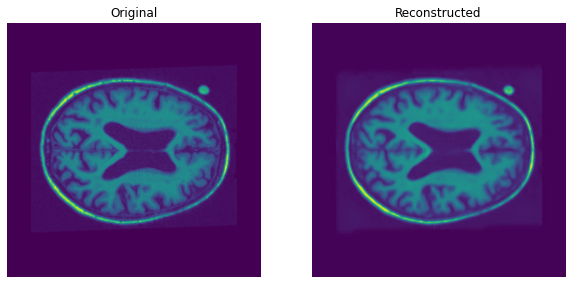

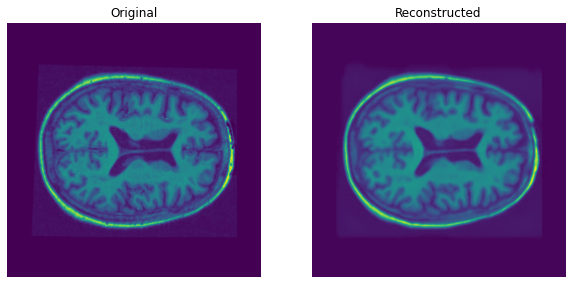

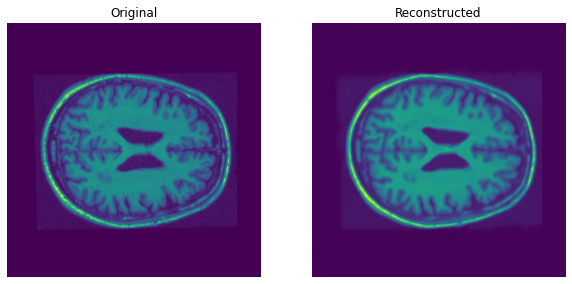

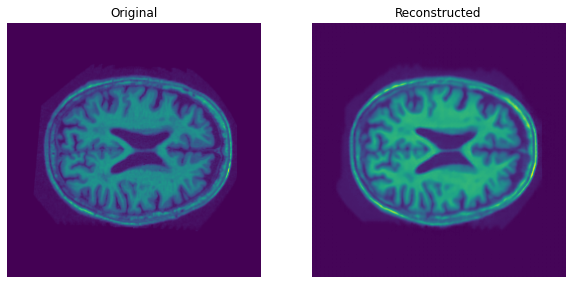

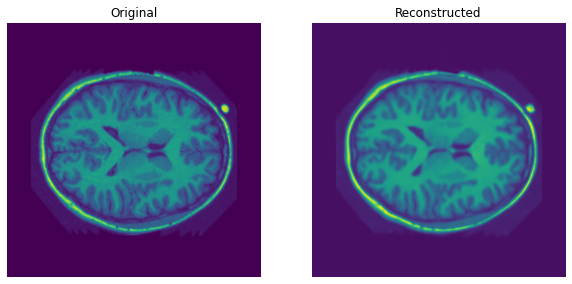

In [4]:
def show_subplot(original, reconstructed):

    original = original + 0.5
    reconstructed = reconstructed + 0.5

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(original[:, :, 0])
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed[:, :, 0])
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


test_images = next(iter(test_ds))
reconstructions_test = trained_vqvae_model.predict(test_images)

for i in range(5):
    show_subplot(test_images[i], reconstructions_test[i])

Low filter encoder is (20, 32, 32, 256), High filter encoder is (20, 64, 64, 128)


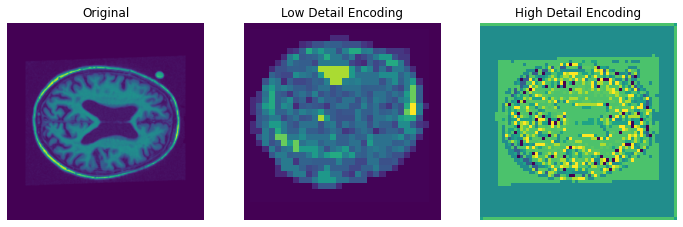

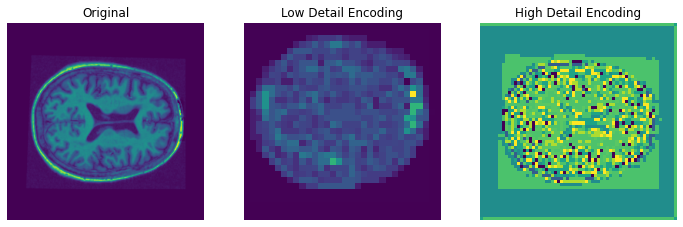

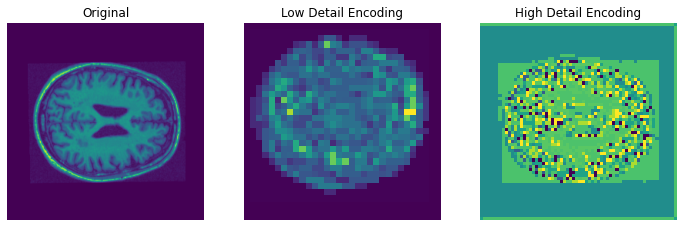

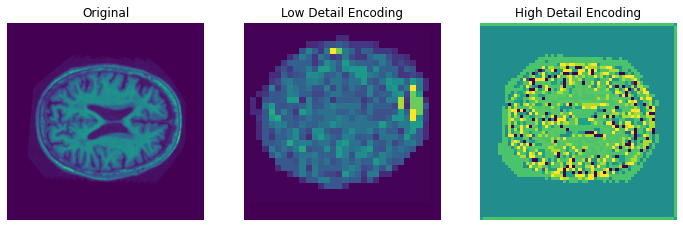

In [5]:
# Testing encoding visualisation
enc_out_t, enc_out_b = trained_vqvae_model.encode(test_images)
print(f"Low filter encoder is {enc_out_t.shape}, High filter encoder is {enc_out_b.shape}")

for i in range(4):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i][:, :, 0] + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(enc_out_t[i][:, :, 0] + 0.5)
    plt.title("Low Detail Encoding")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(enc_out_b[i][:, :, 0] + 0.5)
    plt.title("High Detail Encoding")
    plt.axis("off")
    plt.show()


In [6]:
ssim_total = 0
count = 0

for batch in tqdm(test_ds):
    reconstructed_comp = trained_vqvae_model.predict(batch)

    for i in range(batch.shape[0]):
        original = tf.math.round((batch[i] + 0.5) * 255.0)
        reconstruction = tf.math.round((reconstructed_comp[i] + 0.5) * 255.0)
        ssim = tf.image.ssim(original, reconstruction, max_val=255.0)
        ssim_total += ssim
        count += 1

print(f"Average SSIM score is {ssim_total / count}.")

  0%|          | 0/28 [00:00<?, ?it/s]

Average SSIM score is 0.9380497336387634.


In [9]:
# Generate an encoded dataset for the PixelCNN
pixel_ds = configure_for_performance(train_ds_raw, 10)
codebook_tensor_t, codebook_tensor_b = gen_codebooks(trained_vqvae_model, pixel_ds)
        

Extracting Codebook Indices::   0%|          | 0/967 [00:00<?, ?it/s]

In [ ]:
# Compile and generate the PixelCNN models for each layer of the VQVAE
pixel_cnn_t = pixel_cnn((32, 32), filters=128, kernels=11, embeddings=512, name="pixel_cnn_top")
pixel_cnn_b = pixel_cnn((64, 64), filters=128, kernels=11, embeddings=256, name="pixel_cnn_bottom")

pixel_cnn_t.compile(
    optimizer=tf.keras.optimizers.Adam(5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
)

pixel_cnn_b.compile(
    optimizer=tf.keras.optimizers.Adam(5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
)

pixel_cnn_t.load_weights(Path(os.getcwd()) / "models/model022_pixelcnn_t")
pixel_cnn_b.load_weights(Path(os.getcwd()) / "models/model022_pixelcnn_b")

In [ ]:
# Create a mini sampler model
def gen_priors_layer(model, num_samples=10):
    inputs = Input(shape=model.input_shape[1:])
    x = model(inputs, training=False)
    dist = tfp.distributions.Categorical(logits=x)
    sampled = dist.sample()
    sampler = Model(inputs, sampled)

    # Create an empty array of priors.
    priors = np.zeros(shape=(num_samples,) + (model.input_shape)[1:])
    num_samples, rows, cols = priors.shape

    # Iterate over the priors because generation has to be done sequentially pixel by pixel.
    for row in trange(rows, desc="Predicting priors"):
        for col in range(cols):
            # Feed the whole array and retrieving the pixel value probabilities for the next
            # pixel.
            probs = sampler.predict(priors)
            # Use the probabilities to pick pixel values and append the values to the priors.
            priors[:, row, col] = probs[:, row, col]
    return priors

priors_t = gen_priors_layer(pixel_cnn_t)
priors_b = gen_priors_layer(pixel_cnn_b)

In [ ]:
def show_generated_image(samples_t, samples_b):

    generated = trained_vqvae_model.decode(samples_t, samples_b)

    for i in range(samples_t.shape[0]):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(samples_t[i][:, :, 0] + 0.5)
        plt.title("Low Detail Encoding")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(samples_b[i][:, :, 0] + 0.5)
        plt.title("High Detail Encoding")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(generated[i][:, :, 0] + 0.5)
        plt.title("Original")
        plt.axis("off")

        plt.show()

def gen_encodings(priors, quantizer):
    # Perform an embedding lookup.

    encodings = tf.one_hot(priors, quantizer.num_embeddings)
    quantized = tf.matmul(encodings, quantizer.embeddings, transpose_b=True)
    quantized = tf.reshape(quantized, priors.shape + (quantizer.embedding_dim,))

    return quantized

print(priors_t.shape)
pad_t = gen_encodings(priors_t, trained_vqvae_model.quantize_t)
pad_b = gen_encodings(priors_b, trained_vqvae_model.quantize_b)

show_generated_image(pad_t, pad_b)